# Server-side Property Inference Attacks against Split Learning: `credit-card`

## Import packages and dataset

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import property_attack
from property_attack import *
from datasets import *

In [2]:
def num2cat(num):
    if num == 1:
        return [0.]
    else:
        return [1.]

xpriv, xpub = load_credit_card(normalization="feature", property_id=1, num2cat=num2cat)

## Setting up hyperparameters and util functions

In [3]:
batch_size = 64
id_setup = 4
hparams = {
    'WGAN' : True,
    # 'gradient_penalty' : 500.,
    'style_loss' : None,
    'lr_f' :  0.00001,
    'lr_tilde' : 0.00001,
    'lr_D' : 0.0001,
    'lr_classify': 0.000001,
}

iterations = 10000
log_frequency = 200

def plot_log(ax, x, y, label=None, color='blue'):
    ax.plot(x, y, color=color)
    ax.grid()
    if label is not None:
        ax.set(title=label)

## Model architectures

In [4]:
def f(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.BatchNormalization()(xin)
    x = tf.keras.layers.Dense(32, activation="relu")(xin)
    output = tf.keras.layers.Dense(64, activation="relu")(x)
    return tf.keras.Model(xin, output)

def g(input_shape, class_num):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(128, activation="relu")(xin)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(xin, output)

def encoder(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = "relu"
    x = tf.keras.layers.Dense(32, activation=act)(xin)
    x = tf.keras.layers.Dense(32, activation=act)(x)
    x = tf.keras.layers.Dense(64, activation=act)(x)
    x = tf.keras.layers.Dense(64, activation=act)(x)
    return tf.keras.Model(xin, x)

def classifier(input_shape, channels=3):
    xin = tf.keras.layers.Input(input_shape)
    act = "relu"
    x = tf.keras.layers.Dense(128, activation=act)(xin)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(xin, output)

def discriminator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(256)(xin)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(xin, x)

def get_property(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = xin[:][1]
    return tf.keras.Model(xin, x)

In [5]:
models = (f, g, encoder, classifier, discriminator, get_property)

## Property inference attack

In [6]:
passive = property_inference_attack(
    models = models,
    xpriv = xpriv,
    xpub = xpub,
    batch_size = batch_size,
    hparams = hparams,
    class_num = 2)

log_passive = passive(iterations, verbose=True, progress_bar=False, log_frequency=log_frequency)

RUNNING...
[log--01%-0000199] property inference loss: 0.7220 accuracy: 0.2183
Server-side classifier: loss: 0.7012 accuracy: 0.3113
[log--03%-0000399] property inference loss: 0.6971 accuracy: 0.4278
Server-side classifier: loss: 0.6861 accuracy: 0.7729
[log--05%-0000599] property inference loss: 0.6700 accuracy: 0.7708
Server-side classifier: loss: 0.6618 accuracy: 0.7734
[log--07%-0000799] property inference loss: 0.6451 accuracy: 0.7837
Server-side classifier: loss: 0.6244 accuracy: 0.7718
[log--09%-0000999] property inference loss: 0.6270 accuracy: 0.7818
Server-side classifier: loss: 0.6061 accuracy: 0.7741
[log--11%-0001199] property inference loss: 0.6138 accuracy: 0.7771
Server-side classifier: loss: 0.5985 accuracy: 0.7735
[log--13%-0001399] property inference loss: 0.6016 accuracy: 0.7819
Server-side classifier: loss: 0.5906 accuracy: 0.7725
[log--15%-0001599] property inference loss: 0.5934 accuracy: 0.7804
Server-side classifier: loss: 0.5829 accuracy: 0.7732
[log--17%-000

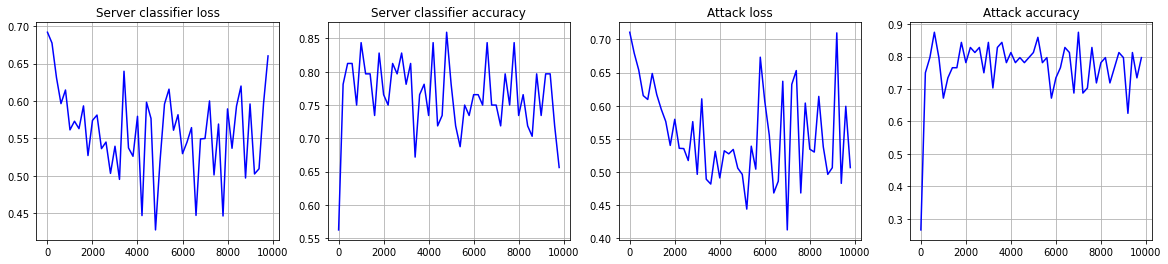

In [32]:
n = 4
fix, ax = plt.subplots(1, n, figsize=(n*5, 4))
x = np.arange(0, len(log_passive)) * log_frequency

plot_log(ax[0], x, log_passive[:, 0],  label='Server classifier loss')
plot_log(ax[1], x, log_passive[:, 1],  label='Server classifier accuracy')
plot_log(ax[2], x, log_passive[:, 2],  label='Attack loss')
plot_log(ax[3], x, log_passive[:, 3],  label='Attack accuracy')

In [34]:
np.savetxt('./log/tabular/property/log_with_xpub.csv', log_passive, delimiter=',')

## Let's ditch X_pub!

In [6]:
def num2cat(num):
    if num == 1:
        return [0.]
    else:
        return [1.]

xpriv, xpub = load_credit_card_without_xpub(property_id=1, num2cat=num2cat)

In [7]:
attack_no_xpub = property_inference_attack(
    models = models,
    xpriv = xpriv,
    xpub = xpub,
    batch_size = batch_size,
    hparams = hparams,
    class_num = 2)

log_no_xpub = attack_no_xpub(iterations, verbose=True, progress_bar=False, log_frequency=log_frequency)

RUNNING...
[log--01%-0000199] property inference loss: 0.6770 accuracy: 0.7671
Server-side classifier: loss: 0.6928 accuracy: 0.5152
[log--03%-0000399] property inference loss: 0.6507 accuracy: 0.7789
Server-side classifier: loss: 0.6264 accuracy: 0.9979
[log--05%-0000599] property inference loss: 0.6255 accuracy: 0.7766
Server-side classifier: loss: 0.5267 accuracy: 1.0000
[log--07%-0000799] property inference loss: 0.6046 accuracy: 0.7784
Server-side classifier: loss: 0.4256 accuracy: 1.0000
[log--09%-0000999] property inference loss: 0.5894 accuracy: 0.7770
Server-side classifier: loss: 0.3657 accuracy: 1.0000
[log--11%-0001199] property inference loss: 0.5723 accuracy: 0.7838
Server-side classifier: loss: 0.3707 accuracy: 1.0000
[log--13%-0001399] property inference loss: 0.5664 accuracy: 0.7751
Server-side classifier: loss: 0.3535 accuracy: 1.0000
[log--15%-0001599] property inference loss: 0.5536 accuracy: 0.7820
Server-side classifier: loss: 0.3458 accuracy: 1.0000
[log--17%-000

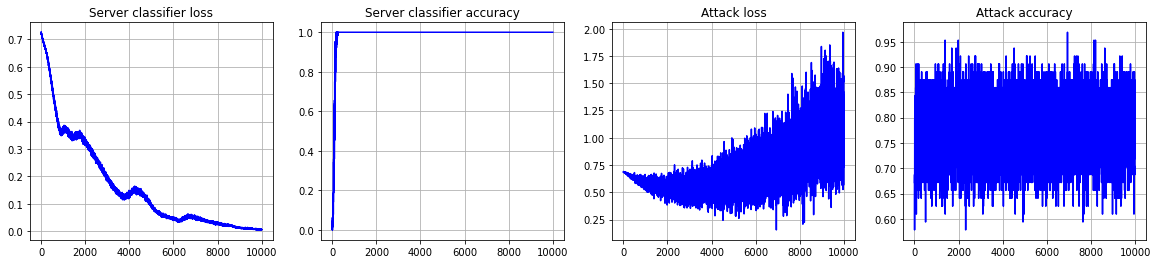

In [30]:
n = 4
fix, ax = plt.subplots(1, n, figsize=(n*5, 4))
x = np.arange(0, len(log_no_xpub))

plot_log(ax[0], x, log_no_xpub[:, 0],  label='Server classifier loss')
plot_log(ax[1], x, log_no_xpub[:, 1],  label='Server classifier accuracy')
plot_log(ax[2], x, log_no_xpub[:, 2],  label='Attack loss')
plot_log(ax[3], x, log_no_xpub[:, 3],  label='Attack accuracy')

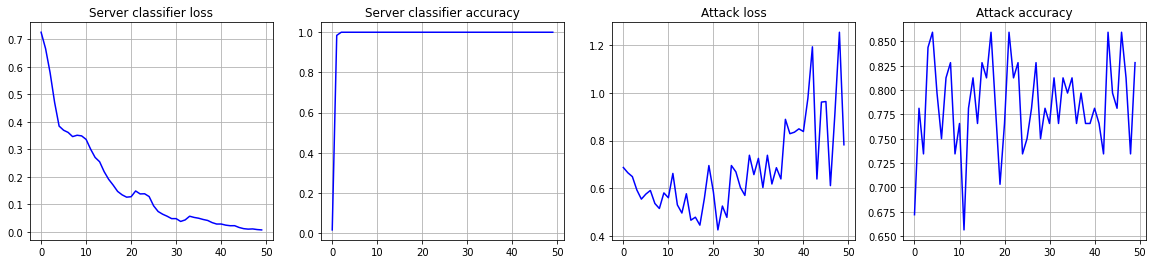

In [57]:
log_no_xpub_sampled = log_no_xpub[[i*log_frequency for i in range(len(log_no_xpub)//log_frequency)]]
x = np.arange(0, len(log_no_xpub)//log_frequency)

n = 4
fix, ax = plt.subplots(1, n, figsize=(n*5, 4))

plot_log(ax[0], x, log_no_xpub_sampled[:, 0],  label='Server classifier loss')
plot_log(ax[1], x, log_no_xpub_sampled[:, 1],  label='Server classifier accuracy')
plot_log(ax[2], x, log_no_xpub_sampled[:, 2],  label='Attack loss')
plot_log(ax[3], x, log_no_xpub_sampled[:, 3],  label='Attack accuracy')

In [33]:
np.savetxt('./log/tabular/property/log_no_xpub.csv', log_no_xpub, delimiter=',')